In [1]:
from tools import load_config
# Import necessary libraries
import pandas as pd

from sklearn.linear_model import LogisticRegression


from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

import numpy as np


# Load the config.yaml
config = load_config("config.yaml")

# Extract the processed data location
processed_data_location = config["processed_data_location"]

# Load the processed data into a DataFrame
import pandas as pd
data = pd.read_csv(processed_data_location)

# Display the DataFrame
data.head()


c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\config.yaml


,subjid,sex,vomitfl,temp,virusfl,hosp_days,age_years,antibioticfl,probioticfl,analgesicfl,treatment_combination,combination_description,dehsev_Mild dehydration,dehsev_No dehydration,dehsev_Severe dehydration,BMI,vomit_avgfrq
0,1,2,1,37.8,1,3,0.393607,0,0,0,0,No treatments,False,False,True,13.611111,2.5
1,2,1,1,39.0,1,3,1.893607,0,0,0,0,No treatments,True,False,False,13.442554,3.5
2,3,1,0,37.1,1,5,1.868950,0,0,0,0,No treatments,True,False,False,19.333730,NaN
3,4,2,1,37.7,1,2,0.657306,0,0,1,1,Analgesic only,False,False,True,16.568047,2.5
4,7,1,1,36.5,1,1,0.885388,0,0,0,0,No treatments,False,False,True,11.108907,1.5


In [2]:
data.columns = data.columns.str.strip().str.replace(" ", "_")

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Prepare the data
unique_treatment_combinations = data['treatment_combination'].unique()
covariates = [
    'age_years', 'sex', 'BMI', 'temp', 
    'vomitfl', 'virusfl', 
    'dehsev_Mild_dehydration', 
    'dehsev_Severe_dehydration'
]
scaler = StandardScaler()
X = scaler.fit_transform(data[covariates])

def psm(data, X, treatment_combinations):
    """
    Perform Propensity Score Matching (PSM) for multiple treatment groups.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the treatment and covariate data.
        X (np.ndarray): Scaled covariates used to estimate propensity scores.
        treatment_combinations (list): List of unique treatment combinations.
        
    Returns:
        dict: Dictionary where each treatment group is mapped to its matched pairs dataframe.
    """
    binary_psm_results = {}
    
    for treatment_group in treatment_combinations:
        # Create binary treatment variable
        data['binary_treatment'] = (data['treatment_combination'] == treatment_group).astype(int)
        
        # Estimate propensity scores for the binary treatment
        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X, data['binary_treatment'])
        data['propensity_score'] = logreg.predict_proba(X)[:, 1]
        
        # Perform nearest-neighbor matching
        treated_idx = data[data['binary_treatment'] == 1].index
        control_idx = data[data['binary_treatment'] == 0].index
        
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(data.loc[control_idx, 'propensity_score'].values.reshape(-1, 1))
        distances, neighbors = nn.kneighbors(
            data.loc[treated_idx, 'propensity_score'].values.reshape(-1, 1)
        )
        
        # Store matched pairs
        matched_pairs = pd.DataFrame({
            'treated': treated_idx,
            'matched': control_idx[neighbors.flatten()],
            'distance': distances.flatten()
        })
        
        binary_psm_results[treatment_group] = matched_pairs
    
    return binary_psm_results

def evaluate_balance(matched_pairs, data, covariates):
    """
    Evaluate covariate balance for matched pairs.
    
    Parameters:
        matched_pairs (pd.DataFrame): DataFrame containing treated and matched indices.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame with covariates and their standardized differences.
    """
    balance = []
    for cov in covariates:
        treated_vals = data.loc[matched_pairs['treated'], cov].values
        matched_vals = data.loc[matched_pairs['matched'], cov].values
        standardized_diff = (treated_vals.mean() - matched_vals.mean()) / data[cov].std()
        balance.append({'Covariate': cov, 'Standardized Difference': standardized_diff})
    return pd.DataFrame(balance)

# Perform PSM
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for one of the groups
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance
balance = evaluate_balance(selected_matched_pairs, data, covariates)


In [34]:
balance

,Covariate,Standardized Difference
0,age_years,0.023108
1,sex,0.021294
2,BMI,-0.180765
3,temp,0.124167
4,vomitfl,-0.049660
5,virusfl,-0.104539
6,dehsev_Mild_dehydration,-0.124803
7,dehsev_Severe_dehydration,0.114917


In [35]:
balance

,Covariate,Standardized Difference
0,age_years,0.023108
1,sex,0.021294
2,BMI,-0.180765
3,temp,0.124167
4,vomitfl,-0.049660
5,virusfl,-0.104539
6,dehsev_Mild_dehydration,-0.124803
7,dehsev_Severe_dehydration,0.114917


In [36]:
combination_mapping = {
    '000': 'Без лікування',
    '100': 'Тільки антибіотик',
    '010': 'Тільки пробіотик',
    '001': 'Тільки анальгетик',
    '110': 'Антибіотик і пробіотик',
    '101': 'Антибіотик і анальгетик',
    '011': 'Пробіотик і анальгетик',
    '111': 'Усі три види лікування'
}


In [37]:
combination_mapping['0'] = 'Без лікування'


In [38]:
combination_mapping.update({
    '1': 'Тільки пробіотик',
    '10': 'Тільки анальгетик',
    '11': 'Пробіотик і анальгетик'
})

In [39]:
# Function to calculate and collect balance for all treatment groups
def calculate_all_balances(psm_results, data, covariates):
    """
    Calculate covariate balance for all treatment groups.
    
    Parameters:
        psm_results (dict): Dictionary of matched pairs for each treatment group.
        data (pd.DataFrame): The original dataset containing covariates.
        covariates (list): List of covariate column names.
        
    Returns:
        pd.DataFrame: DataFrame containing covariate balances for all treatment groups.
    """
    all_balances = []
    for group in psm_results:
        matched_pairs = psm_results[group]
        group_balance = evaluate_balance(matched_pairs, data, covariates)
        group_balance['Treatment Group'] = group
        all_balances.append(group_balance)
    return pd.concat(all_balances, ignore_index=True)

# Perform PSM for all treatment groups
binary_psm_results = psm(data, X, unique_treatment_combinations)

# Evaluate balance for a selected treatment group
selected_group = unique_treatment_combinations[1]  # Pick any group to analyze
selected_matched_pairs = binary_psm_results[selected_group]

# Calculate covariate balance for the selected group
balance = evaluate_balance(selected_matched_pairs, data, covariates)

# Calculate balances for all treatment groups
all_balances = calculate_all_balances(binary_psm_results, data, covariates)


In [40]:
all_balances

,Covariate,Standardized Difference,Treatment Group
0,age_years,0.101993,0
1,sex,-0.095735,0
2,BMI,0.015915,0
3,temp,-0.007396,0
4,vomitfl,-0.039400,0
...,...,...,...
59,temp,0.805406,110
60,vomitfl,1.191838,110
61,virusfl,0.000000,110
62,dehsev_Mild_dehydration,0.000000,110


In [41]:
# Convert 'Treatment Group' to string before mapping
all_balances['Treatment Group'] = all_balances['Treatment Group'].astype(str)
all_balances['Treatment Group Name'] = all_balances['Treatment Group'].map(combination_mapping)


In [42]:
covariate_mapping = {
    'age_years': 'Вік (роки)',
    'sex': 'Стать',
    'BMI': 'ІМТ (Індекс маси тіла)',
    'temp': 'Температура',
    'vomitfl': 'Блювота',
    'virusfl': 'Вірусна інфекція',
    'dehsev_Mild_dehydration': 'Легке зневоднення',
    'dehsev_Severe_dehydration': 'Важке зневоднення',    
    'dehsev_No_dehydration': 'Немає зневоднення'
}

# Перейменування коваріатів в даних
all_balances['Covariate'] = all_balances['Covariate'].map(covariate_mapping)


In [43]:
# Identify any treatment groups that were not mapped (if any)
unmapped_groups = data[data['treatment_combination'].isna()]['treatment_combination'].unique()
if len(unmapped_groups) > 0:
    print("\nUnmapped treatment groups found:")
    print(unmapped_groups)
else:
    print("\nAll treatment groups mapped successfully.")


All treatment groups mapped successfully.


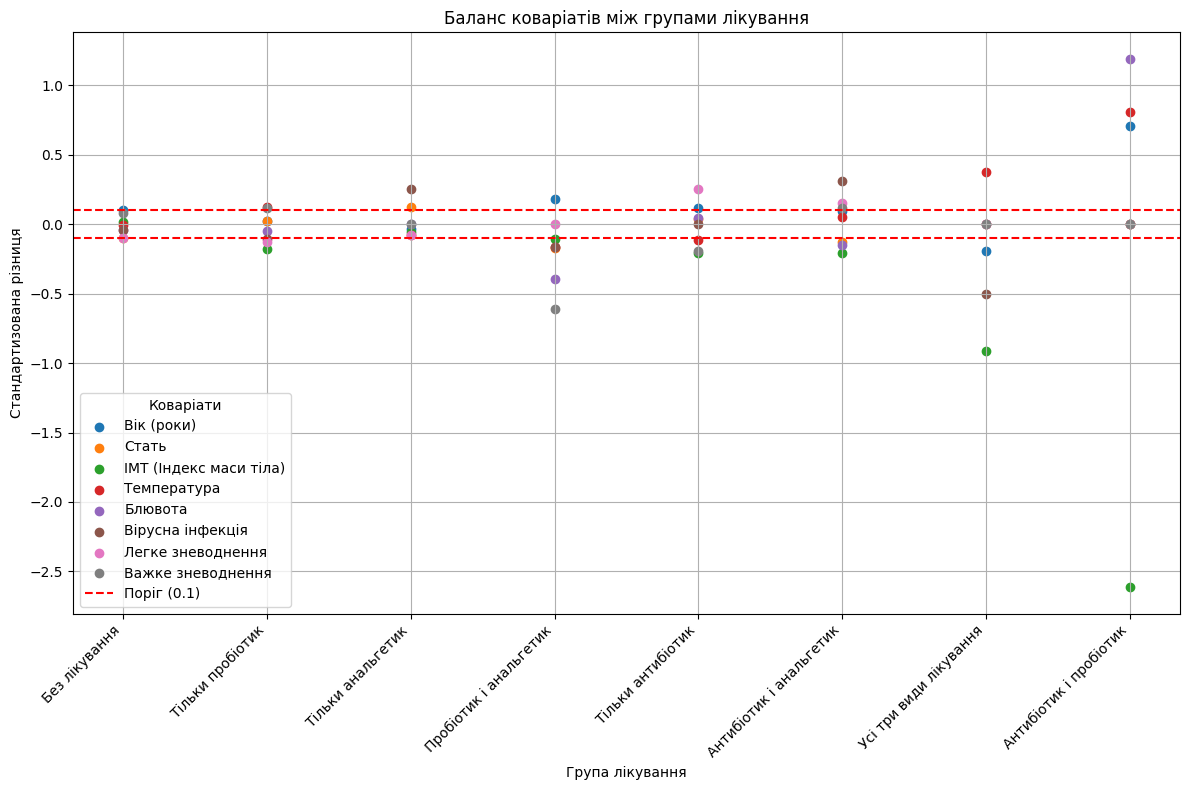

In [44]:
import matplotlib.pyplot as plt

# Побудова графіка
plt.figure(figsize=(12, 8))
for cov in covariates:
    subset = all_balances[all_balances['Covariate'] == covariate_mapping[cov]]
    plt.scatter(subset['Treatment Group Name'], subset['Standardized Difference'], label=covariate_mapping[cov])

# Додаткові деталі графіка
plt.axhline(y=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axhline(y=-0.1, color='r', linestyle='--')
plt.title('Баланс коваріатів між групами лікування')
plt.xlabel('Група лікування')
plt.ylabel('Стандартизована різниця')
plt.xticks(rotation=45, ha='right')  # Поворот підписів на осі X
plt.legend(title='Коваріати')
plt.grid(True)
plt.tight_layout()  # Автоматичне налаштування макета
plt.show()


In [45]:
# Define the selected treatment groups as integers
selected_groups = [0, 10, 1, 100]  # Corresponding to '000', '010', '001', '100'

# Filter the dataset for the selected treatment groups
filtered_data = data[data['treatment_combination'].isin(selected_groups)].copy()

In [46]:
# Standardize covariates
scaler = StandardScaler()
X_filtered = scaler.fit_transform(filtered_data[covariates])

# Perform Propensity Score Matching for the selected treatment groups
binary_psm_results = psm(filtered_data, X_filtered, selected_groups)

# Calculate covariate balance for all selected groups using the pre-defined function
all_balances_df = calculate_all_balances(binary_psm_results, filtered_data, covariates)

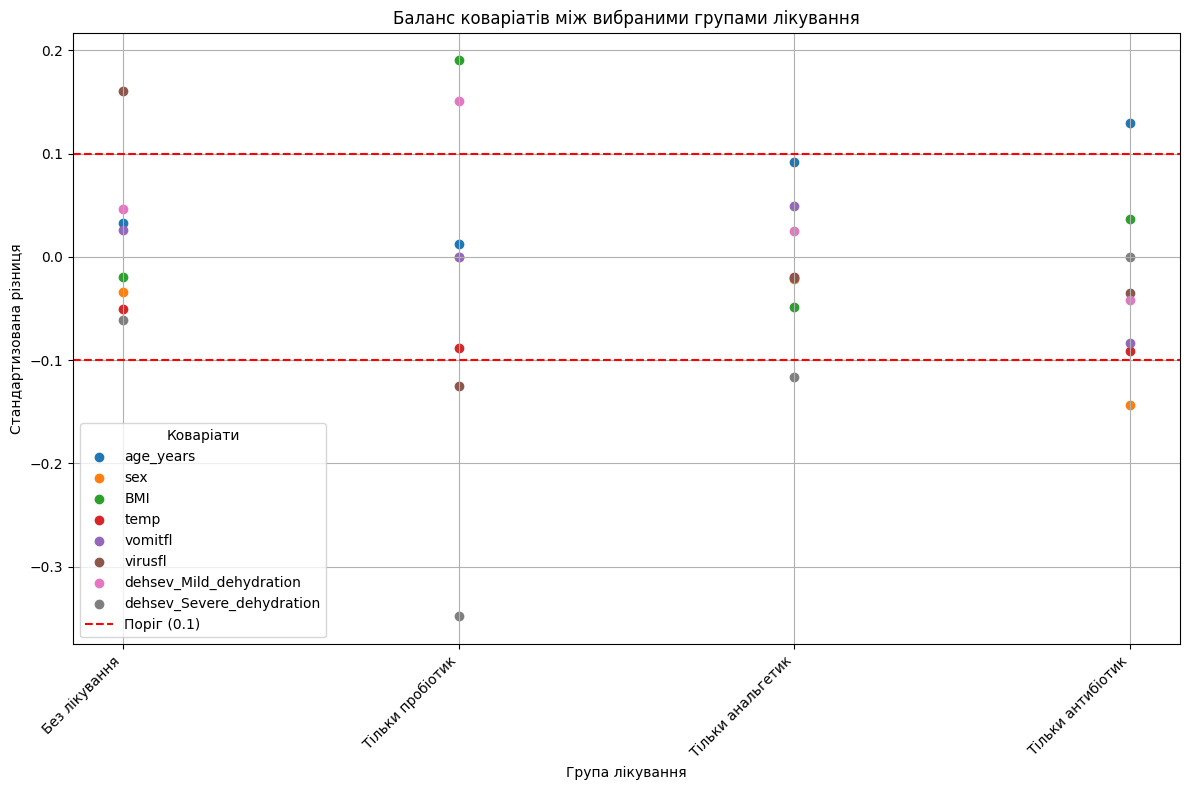

In [47]:
import matplotlib.pyplot as plt

group_mapping = {
    0: 'Без лікування',
    10: 'Тільки пробіотик',
    1: 'Тільки анальгетик',
    100: 'Тільки антибіотик'
}
all_balances_df['Treatment Group Name'] = all_balances_df['Treatment Group'].map(group_mapping)

# Plot balance
plt.figure(figsize=(12, 8))
for cov in covariates:
    subset = all_balances_df[all_balances_df['Covariate'] == cov]
    plt.scatter(subset['Treatment Group Name'], subset['Standardized Difference'], label=cov)

# Add threshold lines and plot details
plt.axhline(y=0.1, color='r', linestyle='--', label='Поріг (0.1)')
plt.axhline(y=-0.1, color='r', linestyle='--')
plt.title('Баланс коваріатів між вибраними групами лікування')
plt.xlabel('Група лікування')
plt.ylabel('Стандартизована різниця')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.legend(title='Коваріати')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [75]:
# Combine all matched pairs from PSM results
all_matched_pairs = pd.concat(
    [binary_psm_results[group] for group in binary_psm_results], 
    ignore_index=True
)


In [76]:
# Retrieve matched treated and control subjects
matched_treated = data.loc[all_matched_pairs['treated']]
matched_control = data.loc[all_matched_pairs['matched']]

# Combine treated and control subjects into a single DataFrame
matched_subjects = pd.concat([matched_treated, matched_control], ignore_index=True)

# Add a column indicating treatment/control status
matched_subjects['treatment_status'] = ['Treated'] * len(matched_treated) + ['Control'] * len(matched_control)


In [77]:
# Count the number of subjects by treatment combination
print(matched_subjects['treatment_combination'].value_counts())

# Inspect the matched data
print(matched_subjects.head())


treatment_combination
0      510
1      299
100    179
10     108
Name: count, dtype: int64
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  antibioticfl  \
0       1    2        1  37.8        1          3   0.393607             0   
1       2    1        1  39.0        1          3   1.893607             0   
2       3    1        0  37.1        1          5   1.868950             0   
3       7    1        1  36.5        1          1   0.885388             0   
4      12    1        1  38.6        1          3   0.621689             0   

   probioticfl  analgesicfl  treatment_combination combination_description  \
0            0            0                      0           No treatments   
1            0            0                      0           No treatments   
2            0            0                      0           No treatments   
3            0            0                      0           No treatments   
4            0            0                      

In [78]:
# Get the count of subjects in each treatment combination
group_sizes = matched_subjects['treatment_combination'].value_counts()

# Determine the smallest group size
min_group_size = group_sizes.min()
print("Smallest group size:", min_group_size)


Smallest group size: 108


In [79]:
# Downsample each treatment group
balanced_subjects = matched_subjects.groupby('treatment_combination').apply(
    lambda group: group.sample(n=min_group_size, random_state=42)
).reset_index(drop=True)


C:\Users\Danylo\AppData\Local\Temp\ipykernel_20340\2593257039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_subjects = matched_subjects.groupby('treatment_combination').apply(


In [83]:
# Verify the balanced counts
print("Balanced counts by treatment combination:")
print(balanced_subjects['treatment_combination'].value_counts())

# Preview the balanced dataset
print("Balanced dataset preview:")
print(balanced_subjects.head())


Balanced counts by treatment combination:
treatment_combination
0      108
1      108
10     108
100    108
Name: count, dtype: int64
Balanced dataset preview:
   subjid  sex  vomitfl  temp  virusfl  hosp_days  age_years  antibioticfl  \
0     418    1        0  37.8        1          2   4.000000             0   
1     556    2        1  37.5        1          4   0.433105             0   
2     454    2        0  36.7        1          2   0.666667             0   
3     847    1        1  37.5        1          4   1.116210             0   
4     235    1        0  36.9        1          2   0.299315             0   

   probioticfl  analgesicfl  treatment_combination combination_description  \
0            0            0                      0           No treatments   
1            0            0                      0           No treatments   
2            0            0                      0           No treatments   
3            0            0                      0         

In [85]:
# Split balanced_subjects into treatment and control groups
treated_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Treated']
control_data = balanced_subjects[balanced_subjects['treatment_status'] == 'Control']


In [86]:
# Function to calculate standardized differences for flat datasets
def calculate_standardized_difference(treated, control, covariate):
    treated_vals = treated[covariate].values
    control_vals = control[covariate].values
    treated_mean = treated_vals.mean()
    control_mean = control_vals.mean()
    pooled_std = ((treated_vals.var() + control_vals.var()) / 2) ** 0.5
    return (treated_mean - control_mean) / pooled_std

# Evaluate balance for each covariate
balanced_covariate_balance = []
for cov in covariates:
    std_diff = calculate_standardized_difference(treated_data, control_data, cov)
    balanced_covariate_balance.append({'Covariate': cov, 'Standardized Difference': std_diff})

# Convert to DataFrame
balanced_covariate_balance = pd.DataFrame(balanced_covariate_balance)


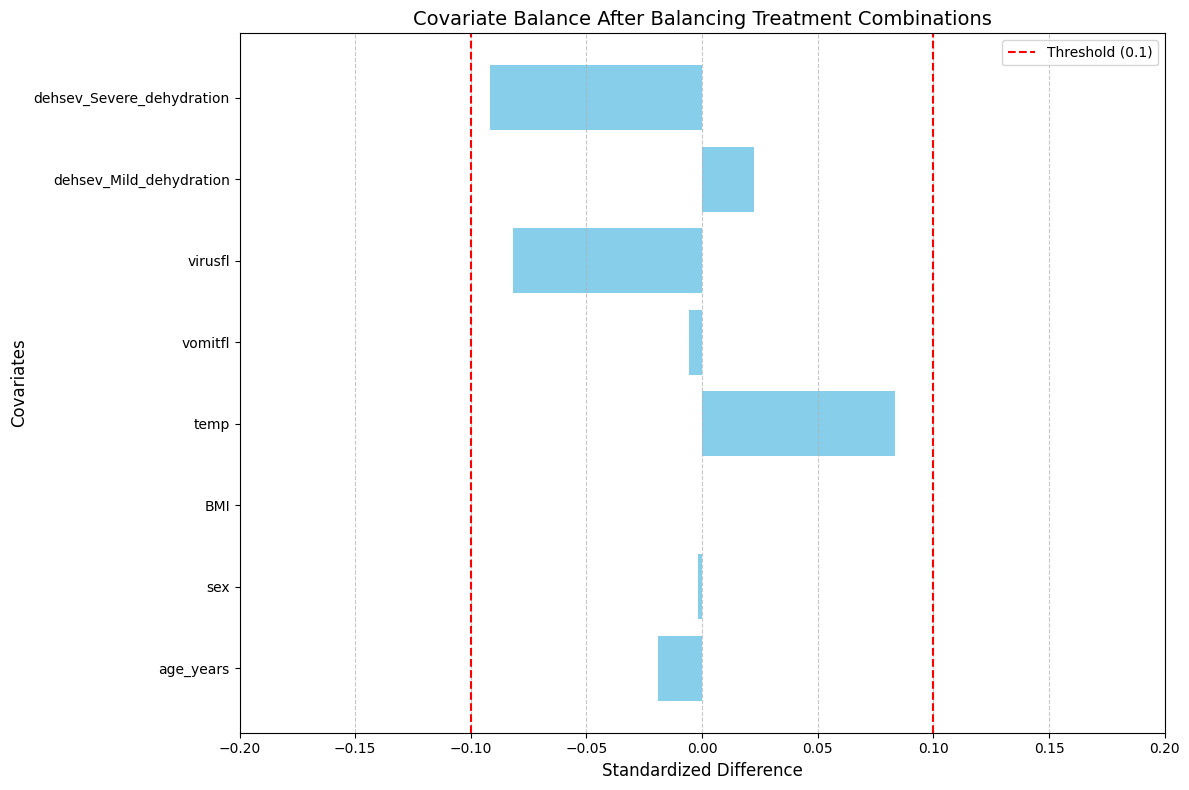

In [92]:
# Visualize covariate balance with a bar chart
plt.figure(figsize=(12, 8))

# Bar chart for covariate balance
plt.barh(
    balanced_covariate_balance['Covariate'], 
    balanced_covariate_balance['Standardized Difference'], 
    color='skyblue'
)

# Add threshold lines
plt.axvline(x=0.1, color='r', linestyle='--', label='Threshold (0.1)')
plt.axvline(x=-0.1, color='r', linestyle='--')

# Explicitly set x-axis limits to show -0.5 to 0.5
plt.xlim(-0.2, 0.2)

# Add titles and labels
plt.title('Covariate Balance After Balancing Treatment Combinations', fontsize=14)
plt.xlabel('Standardized Difference', fontsize=12)
plt.ylabel('Covariates', fontsize=12)

# Add grid and legend
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()


In [88]:
balanced_covariate_balance

,Covariate,Standardized Difference
0,age_years,-0.019169
1,sex,-0.001645
2,BMI,0.000116
3,temp,0.083419
4,vomitfl,-0.005472
5,virusfl,-0.081890
6,dehsev_Mild_dehydration,0.022542
7,dehsev_Severe_dehydration,-0.091617


In [93]:
# Calculate the median hospital stay
median_hosp_days = balanced_subjects['hosp_days'].median()
print(f"Median Hospital Stay: {median_hosp_days} days")


Median Hospital Stay: 4.0 days


In [94]:
# Define the event status based on hospital stay
balanced_subjects['event_occurred'] = (balanced_subjects['hosp_days'] > median_hosp_days).astype(int)


In [95]:
# Use hospital stay as the survival time
balanced_subjects['survival_time'] = balanced_subjects['hosp_days']


In [101]:
balanced_subjects['treatment_combination'].unique()

array([  0,   1,  10, 100])

In [110]:
# Encode treatment_combination as categorical
data_with_dummies = pd.get_dummies(
    balanced_subjects, 
    columns=['treatment_combination'], 
    drop_first=True  # Drop one category to avoid multicollinearity
)

# Inspect the new dataset with dummy variables
print(data_with_dummies.columns)


Index(['subjid', 'sex', 'vomitfl', 'temp', 'virusfl', 'hosp_days', 'age_years',
       'antibioticfl', 'probioticfl', 'analgesicfl', 'combination_description',
       'dehsev_Mild_dehydration', 'dehsev_No_dehydration',
       'dehsev_Severe_dehydration', 'BMI', 'vomit_avgfrq', 'binary_treatment',
       'propensity_score', 'treatment_status', 'event_occurred',
       'survival_time', 'treatment_combination_1', 'treatment_combination_10',
       'treatment_combination_100'],
      dtype='object')


In [111]:
# Define the columns for the Cox model
cox_covariates = ['age_years', 'BMI', 'temp', 'vomitfl', 'sex', 
                  'virusfl', 'dehsev_Mild_dehydration', 'dehsev_Severe_dehydration',
                  'treatment_combination_1', 'treatment_combination_10', 'treatment_combination_100']

cox_data = data_with_dummies[['survival_time', 'event_occurred'] + cox_covariates]


In [112]:
from lifelines import CoxPHFitter

# Fit the Cox Proportional Hazards model
cox_model = CoxPHFitter()
cox_model.fit(cox_data, duration_col='survival_time', event_col='event_occurred')

# Print the summary of results
cox_model.print_summary()


<lifelines.CoxPHFitter: fitted with 432 total observations, 316 right-censored observations>
             duration col = 'survival_time'
                event col = 'event_occurred'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 116
   partial log-likelihood = -425.06
         time fit was run = 2024-11-27 03:09:00 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
age_years                 -0.15      0.86      0.13           -0.41            0.12                0.66                1.12
BMI                        0.01      1.01      0.04           -0.07            0.09                0.93                1.09
temp                      -0.12      0.89      0.13           -0.38            0.14                0.69                1.15
vomitfl                   -0.09      0.91      0.22           -0.52            0.33                0.60                1.39
sex                        0.25      1.28      0.21           -0.16            0.66                0.85                1.93
virusfl                    0.26      1.30      0.21           -0.15            0.67                0.86                1.95
dehsev_Mild_dehydration   -0.17      0.84      0.28           -0.72            0.38                0.49                1.46
dehsev_Severe_dehydration  0.07      1.07      0.45           -0.81            0.95                0.44                2.59
treatment_combination_1    1.44      4.23      0.43            0.61            2.28                1.83                9.78
treatment_combination_10   0.10      1.11      0.45           -0.77            0.98                0.46                2.65
treatment_combination_100  0.69      2.00      0.35            0.01            1.38                1.01                3.98

                           cmp to     z      p  -log2(p)
covariate                                               
age_years                    0.00 -1.09   0.28      1.86
BMI                          0.00  0.13   0.90      0.16
temp                         0.00 -0.90   0.37      1.44
vomitfl                      0.00 -0.44   0.66      0.59
sex                          0.00  1.19   0.23      2.10
virusfl                      0.00  1.24   0.21      2.22
dehsev_Mild_dehydration      0.00 -0.61   0.54      0.88
dehsev_Severe_dehydration    0.00  0.15   0.88      0.19
treatment_combination_1      0.00  3.38 <0.005     10.41
treatment_combination_10     0.00  0.23   0.82      0.28
treatment_combination_100    0.00  1.98   0.05      4.40
---
Concordance = 0.67
Partial AIC = 872.12
log-likelihood ratio test = 27.30 on 11 df
-log2(p) of ll-ratio test = 7.92

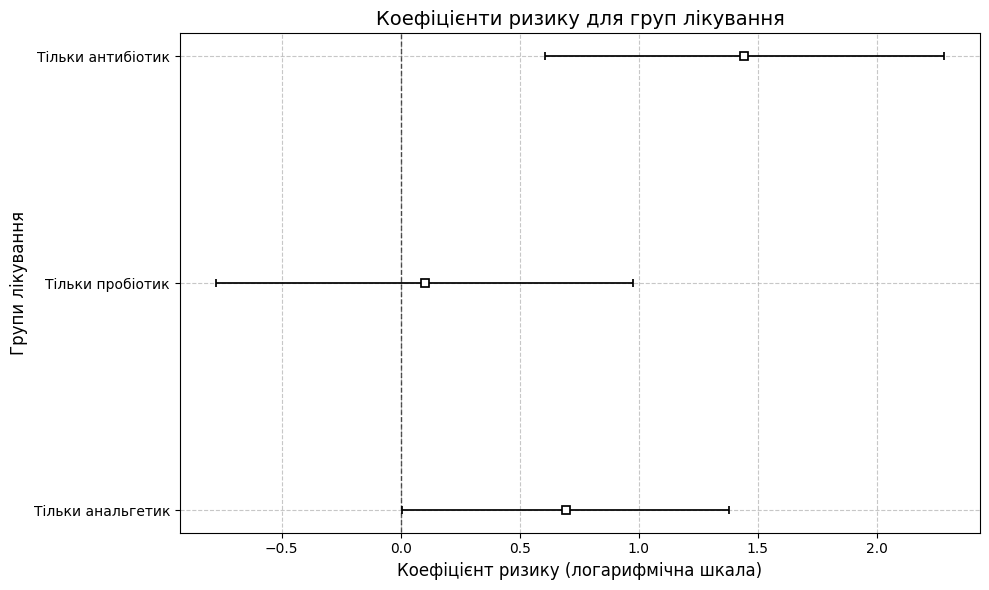

In [117]:
# Filter the model's coefficients to include only treatments
treatment_covariates = [col for col in cox_model.summary.index if col.startswith("treatment_combination")]

# Create a mapping for Ukrainian treatment names
treatment_mapping_ukrainian = {
    "treatment_combination_1": "Тільки анальгетик",
    "treatment_combination_10": "Тільки пробіотик",
    "treatment_combination_100": "Тільки антибіотик"
}

# Plot the hazard ratios for treatment groups only
fig, ax = plt.subplots(figsize=(10, 6))

# Generate the plot for the filtered treatment covariates
cox_model.plot(ax=ax, columns=treatment_covariates)

# Update the labels to Ukrainian
ax.set_yticklabels([treatment_mapping_ukrainian.get(label, label) for label in treatment_covariates])

# Add titles and labels
plt.title('Коефіцієнти ризику для груп лікування', fontsize=14)
plt.xlabel('Коефіцієнт ризику (логарифмічна шкала)', fontsize=12)
plt.ylabel('Групи лікування', fontsize=12)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


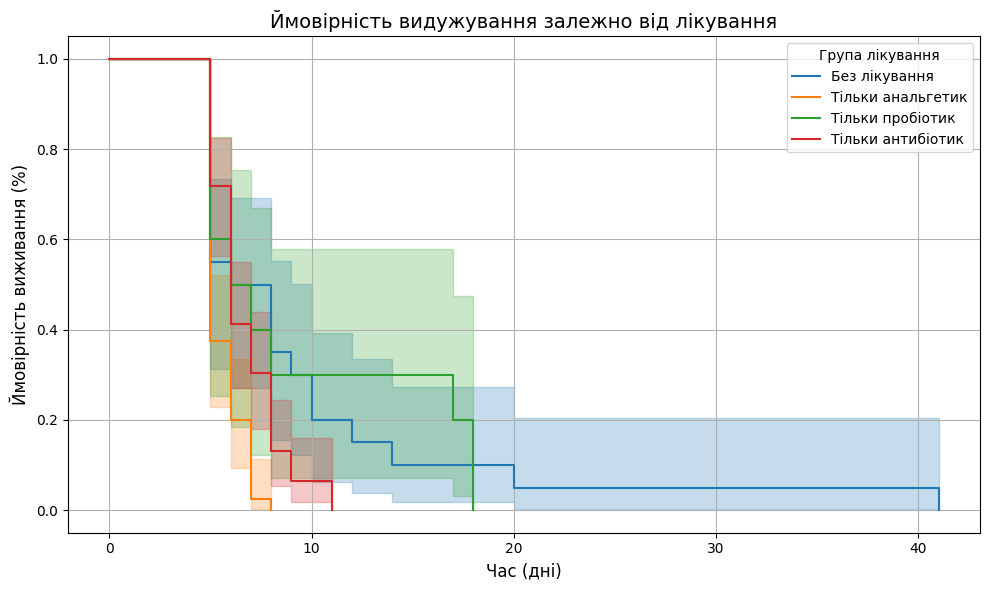

In [108]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Kaplan-Meier survival curves for each treatment group
for treatment in balanced_subjects['treatment_combination'].unique():
    # Filter the data for the specific treatment group
    treatment_data = balanced_subjects[balanced_subjects['treatment_combination'] == treatment]
    
    # Fit the Kaplan-Meier curve
    kmf.fit(
        treatment_data['survival_time'], 
        event_observed=treatment_data['event_occurred'], 
        label=group_mapping.get(treatment, f'Група {treatment}')  # Use Ukrainian names
    )
    
    # Plot the survival curve
    kmf.plot_survival_function(ax=ax)

# Add plot details in Ukrainian
plt.title('Ймовірність видужування залежно від лікування', fontsize=14)
plt.xlabel('Час (дні)', fontsize=12)
plt.ylabel('Ймовірність виживання (%)', fontsize=12)
plt.legend(title='Група лікування')
plt.grid(True)
plt.tight_layout()
plt.show()
